In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

pd.set_option("display.max_columns", None)
%matplotlib inline

### ЧАСТЬ 1 EDA и предпроцессинг данных

In [2]:
df = pd.read_csv("data_regression_for_task.csv")
df.columns = [x.lower() for x in df.columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   year           128355 non-null  int64  
 1   month          128355 non-null  int64  
 2   contragent     128331 non-null  object 
 3   article_code   128355 non-null  object 
 4   article_name   128355 non-null  object 
 5   article_group  128354 non-null  object 
 6   sales          128355 non-null  float64
 7   store_sales    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [4]:
df.head()

,year,month,contragent,article_code,article_name,article_group,sales,store_sales
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


In [5]:
df.nunique()

year                 2
month               10
contragent         333
article_code     23556
article_name     23624
article_group        8
sales             7019
store_sales       2518
dtype: int64

In [6]:
print(df["sales"].value_counts())
print()
print(df["store_sales"].value_counts())

0.0         49176
80.0         4923
160.0        2785
170.0        2754
240.0        1743
            ...  
175300.0        1
43550.0         1
64510.0         1
56770.0         1
420720.0        1
Name: sales, Length: 7019, dtype: int64

 0.00       49637
 1.00       24551
 2.00       11523
 3.00        6680
 4.00        4594
            ...  
 4165.00        1
 619.00         1
 702.00         1
 2476.25        1
-81.00          1
Name: store_sales, Length: 2518, dtype: int64


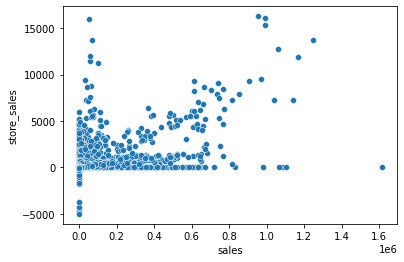

In [7]:
sns.scatterplot(data=df, x="sales", y="store_sales");

In [8]:
df["ym"] = df['year']*100 + df['month']

In [9]:
df.head()

,year,month,contragent,article_code,article_name,article_group,sales,store_sales,ym
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,201704
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,201704
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,201704
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,201704
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,201704


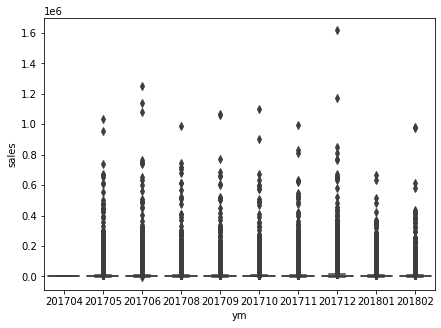

In [10]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="ym", y="sales");

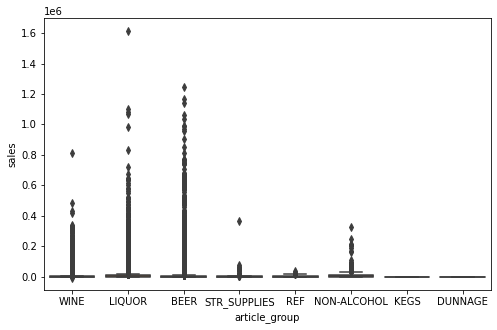

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="article_group", y="sales");

In [12]:
df.loc[df["ym"] == 201704].nunique()

year                1
month               1
contragent        210
article_code     5195
article_name     5192
article_group       6
sales               1
store_sales         1
ym                  1
dtype: int64

In [13]:
df.loc[df["article_group"].isin(["KEGS", "DUNNAGE"])].nunique()

year                2
month               8
contragent         54
article_code     1373
article_name     1384
article_group       2
sales               1
store_sales       176
ym                  8
dtype: int64

Чистка данных:

    - Удалить группы "KEGS", "DUNNAGE"
    - Удалить апрель 2017
    - Удалить товары с нецифровым артикулом

In [14]:
new_article_code = []

for code in df["article_code"]:
    try:
        ac = int(code)
    except:
        ac = 0
    new_article_code.append(ac)

In [15]:
new_df = df.drop(index=pd.Series(new_article_code).loc[pd.Series(new_article_code) == 0].index)

In [16]:
new_df = new_df.loc[(df["ym"] != 201704) & ~df["article_group"].isin(["KEGS", "DUNNAGE"])].reset_index(drop=True)

Создание признака объём. Из названия артикула пытаемся достать его объём. Я решал такую задачу в Х5 с помощью больших регулярных выражений для детекции объёма и меры (ML, L и т.д.), а затем перевода всё в одну меру (кг или литры). Это было затратно по времени, поэтому здесь я сделал очень упрощённый вариант: топ-9 и всё остальное. 

In [17]:
volume = []

for name in new_df["article_name"]:
    try:
        t = name.split("-")[-1].lstrip()
        volume.append(t)
    except:
        volume.append(None)

In [18]:
cat = list(pd.Series(volume).value_counts()[:9].index)

In [19]:
new_cat = []

for i in volume:
    if i in cat:
        new_cat.append(i)
    else:
        new_cat.append("other")

In [20]:
new_df["volume"] = new_cat

In [21]:
contragent = new_df.groupby("contragent", as_index=False)["sales"].agg({"mean_sales": "mean"})\
.sort_values(by="mean_sales")

In [22]:
dict_contragent = {key:value for (key, value) in zip(contragent.index, contragent.contragent)}

In [23]:
from sklearn.preprocessing import OrdinalEncoder

In [24]:
ord_enc = OrdinalEncoder()
ord_enc.fit(contragent)
ord_contragent = ord_enc.transform(contragent)

In [25]:
new_dict_contragent = dict()
for i in range(ord_contragent.shape[0]):
    new_dict_contragent[dict_contragent[ord_contragent[i, 0]]] = ord_contragent[i, 1]

In [26]:
new_df["ord_contragent"] = [new_dict_contragent[x] for x in new_df["contragent"]]

In [27]:
lm_df = new_df.loc[:, ["ym", "ord_contragent", "article_code", "article_group", "volume", "sales", "store_sales"]]
lm_df["article_code"] = lm_df["article_code"].astype(int)

In [28]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [29]:
col_transfrom = ColumnTransformer(
[
    ('one', OneHotEncoder(drop='first'), ["article_group", "volume"]),
    ('scale', StandardScaler(), ["store_sales"])
])

In [30]:
lm_df = pd.concat([pd.DataFrame(col_transfrom.fit_transform(lm_df).toarray(), 
             columns=col_transfrom.get_feature_names_out()),
                   lm_df.loc[:, ["ym", "ord_contragent", "article_code", "sales"]]], axis=1)

### Часть 2 Создание модели

    Порядок действий такой: строим Lasso регрессию, которая зануляет неинформативные переменные,
    затем очищенный датасет подаём в xgboost

In [31]:
x_train = lm_df.loc[lm_df["ym"] < 201801].drop(columns="sales").reset_index(drop=True)
y_train = lm_df.loc[lm_df["ym"] < 201801, "sales"].reset_index(drop=True)

x_valid = lm_df.loc[lm_df["ym"] == 201801].drop(columns="sales").reset_index(drop=True)
y_valid = lm_df.loc[lm_df["ym"] == 201801, "sales"].reset_index(drop=True)

x_test = lm_df.loc[lm_df["ym"] > 201801].drop(columns="sales").reset_index(drop=True)
y_test = lm_df.loc[lm_df["ym"] > 201801, "sales"].reset_index(drop=True)

In [32]:
from sklearn.linear_model import Lasso

In [33]:
lasso = Lasso()
lasso.fit(x_train, y_train)
y_pred_valid = lasso.predict(x_valid)
lasso.coef_

array([ 5.06611484e+03,  6.04951049e+03,  0.00000000e+00,  1.13584335e+04,
        5.78282515e+03,  0.00000000e+00,  2.34874931e+04,  9.06658599e+03,
        3.68529934e+02, -3.32529340e+03, -4.43831090e+03, -8.06602550e+03,
        5.01336089e+03, -6.50115150e+03, -6.39351530e+03,  1.34127429e+04,
        2.56128825e+02,  6.08264261e+01, -9.46120413e-03])

In [34]:
def metric(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [35]:
x_train = x_train.iloc[:, [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]
x_valid = x_valid.iloc[:, [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]
x_test = x_test.iloc[:, [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]

In [36]:
import xgboost as xgb

In [37]:
xgb_train = xgb.DMatrix(x_train, label=y_train)
xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
xgb_test = xgb.DMatrix(x_test, label=y_test)

In [38]:
param = {'booster': 'gblinear', 'nthread': 4, 'objective': 'reg:squarederror',
        'eval_metric': 'rmse'}

In [39]:
evallist = [(xgb_valid, 'eval'), (xgb_train, 'train')]

In [40]:
model_xgb = xgb.train(param, xgb_train, num_boost_round=1000, evals=evallist,
                     early_stopping_rounds=15, verbose_eval=False)

In [42]:
score = metric(model_xgb.predict(xgb_test), y_test)

In [43]:
print(f"Значение метрики: {score}")

Значение метрики: 130.7112387445943
